## Описание данных

**Butterfly Image Classification**

- The dataset features 75 different classes of Butterflies. The dataset contains about 1000+ labelled images including the validation images. Each image belongs to only one butterfly category.

- The label of each image are saved in Training_set.csv.

- The Testing_set.csv contains names of image in test folder, which you need to predict the label and submit to Data Sprint 107 - Butterfly Image Classification.


In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raretears","key":"35e249f9a1c2c63a71b020f5ac1939f8"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d phucthaiv02/butterfly-image-classification

Dataset URL: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification
License(s): CC0-1.0
100% 225M/226M [00:06<00:00, 42.3MB/s]
100% 226M/226M [00:06<00:00, 35.0MB/s]


In [5]:
! unzip '/content/butterfly-image-classification.zip' -d '/content/butterfly-image-classification'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/butterfly-image-classification/train/Image_2348.jpg  
  inflating: /content/butterfly-image-classification/train/Image_2349.jpg  
  inflating: /content/butterfly-image-classification/train/Image_235.jpg  
  inflating: /content/butterfly-image-classification/train/Image_2350.jpg  
  inflating: /content/butterfly-image-classification/train/Image_2351.jpg  
  inflating: /content/butterfly-image-classification/train/Image_2352.jpg  
  inflating: /content/butterfly-image-classification/train/Image_2353.jpg  
  inflating: /content/butterfly-image-classification/train/Image_2354.jpg  
  inflating: /content/butterfly-image-classification/train/Image_2355.jpg  
  inflating: /content/butterfly-image-classification/train/Image_2356.jpg  
  inflating: /content/butterfly-image-classification/train/Image_2357.jpg  
  inflating: /content/butterfly-image-classification/train/Image_2358.jpg  
  inflating: /content

In [6]:
!pip install pytorch-ignite --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 13.0 MB/s eta 0:00:00


In [7]:
! pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=2a73a0f1b586be5a7a817fab52f7af061a7fcaee383031d4b600b7bed4a26ca1
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [8]:
! pip install torchinfo

## Библиотеки

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision.utils import make_grid
from efficientnet_pytorch import EfficientNet
from torchinfo import summary
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping, Checkpoint, global_step_from_engine
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


## Обуение модели


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
train_csv_path = '/content/butterfly-image-classification/Training_set.csv'
train_images_path = '/content/butterfly-image-classification/train'

train_df = pd.read_csv(train_csv_path)

In [12]:
train_transform = v2.Compose([
    v2.Resize([224, 224]),
    v2.RandomHorizontalFlip(0.25),
    v2.RandomRotation(5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

test_transform = v2.Compose([
    v2.Resize([224, 224]),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

Так как у нас фотографии не расположены в отдельных папках мы не можем использовать ImageFolder, создадим свой датасет.

In [13]:
class ButterflyDatasetFromCSV(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.label_to_idx = {label: idx for idx, label in enumerate(self.annotations['label'].unique())}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.annotations.iloc[idx, 1]
        label = self.label_to_idx[label]
        if self.transform:
            image = self.transform(image)
        return image, label



In [14]:
dataset = ButterflyDatasetFromCSV(annotations_file=train_csv_path, img_dir=train_images_path, transform=train_transform)

train_size = int(0.9 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

In [15]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def show_batch(data_loader):
    for images, _ in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0).clamp(0, 1))
        plt.show()
        break

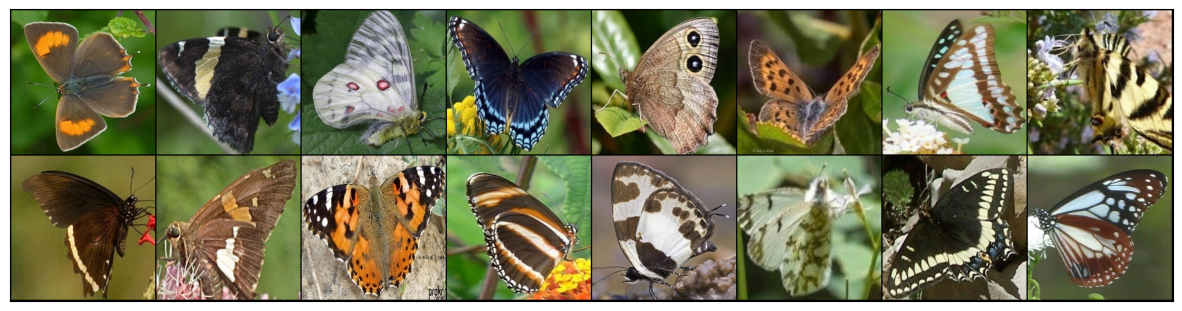

In [16]:
show_batch(train_loader)

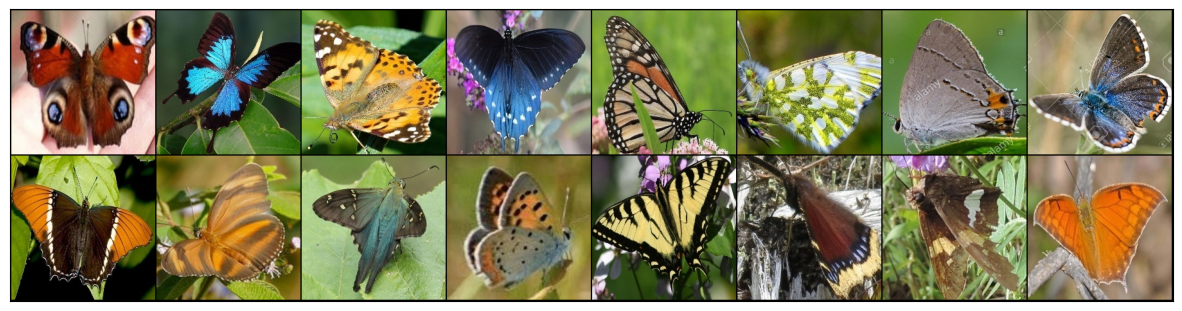

In [17]:
show_batch(test_loader)

С данными всё в порядке, можем приступать к обучению

In [18]:
model = EfficientNet.from_pretrained('efficientnet-b0')
model.to(device)

summary(model, input_size=(1, 3, 224, 224))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 254MB/s]


Loaded pretrained weights for efficientnet-b0


Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [1, 1000]                 --
├─Conv2dStaticSamePadding: 1-1                     [1, 32, 112, 112]         864
│    └─ZeroPad2d: 2-1                              [1, 3, 225, 225]          --
├─BatchNorm2d: 1-2                                 [1, 32, 112, 112]         64
├─MemoryEfficientSwish: 1-3                        [1, 32, 112, 112]         --
├─ModuleList: 1-4                                  --                        --
│    └─MBConvBlock: 2-2                            [1, 16, 112, 112]         --
│    │    └─Conv2dStaticSamePadding: 3-1           [1, 32, 112, 112]         288
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         64
│    │    └─MemoryEfficientSwish: 3-3              [1, 32, 112, 112]         --
│    │    └─Conv2dStaticSamePadding: 3-4           [1, 8, 1, 1]              264
│    │    └─MemoryEfficientSwish

In [19]:
num_cls = len(dataset.label_to_idx)
model._fc = nn.Linear(model._fc.in_features, num_cls)
model.to(device);
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [1, 75]                   --
├─Conv2dStaticSamePadding: 1-1                     [1, 32, 112, 112]         864
│    └─ZeroPad2d: 2-1                              [1, 3, 225, 225]          --
├─BatchNorm2d: 1-2                                 [1, 32, 112, 112]         64
├─MemoryEfficientSwish: 1-3                        [1, 32, 112, 112]         --
├─ModuleList: 1-4                                  --                        --
│    └─MBConvBlock: 2-2                            [1, 16, 112, 112]         --
│    │    └─Conv2dStaticSamePadding: 3-1           [1, 32, 112, 112]         288
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         64
│    │    └─MemoryEfficientSwish: 3-3              [1, 32, 112, 112]         --
│    │    └─Conv2dStaticSamePadding: 3-4           [1, 8, 1, 1]              264
│    │    └─MemoryEfficientSwish

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [23]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)


metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(criterion),
    "cm": ConfusionMatrix(num_classes=num_cls)
}


train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
test_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

training_history = {'accuracy': [], 'loss': []}
validation_history = {'accuracy': [], 'loss': []}

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy'] * 100
    loss = metrics['loss']
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print(f"Тренировка - Эпоха: {trainer.state.epoch} Сред. точность: {accuracy:.2f} Сред. ошибка: {loss:.5f}")


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    accuracy = metrics['accuracy'] * 100
    loss = metrics['loss']
    validation_history['accuracy'].append(accuracy)
    validation_history['loss'].append(loss)
    print(f"Валидация - Эпоха: {trainer.state.epoch} Сред. точность: {accuracy:.2f} Сред. ошибка: {loss:.5f}")


In [24]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = list(dataset.label_to_idx.keys())
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


/usr/local/lib/python3.10/dist-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 1/366 [00:00<?, ?it/s]

Тренировка - Эпоха: 1 Сред. точность: 83.88 Сред. ошибка: 0.53615
Валидация - Эпоха: 1 Сред. точность: 84.26 Сред. ошибка: 0.57995


  0%|          | 1/366 [00:00<?, ?it/s]

Тренировка - Эпоха: 2 Сред. точность: 67.64 Сред. ошибка: 1.23667
Валидация - Эпоха: 2 Сред. точность: 63.89 Сред. ошибка: 1.48735


  0%|          | 1/366 [00:00<?, ?it/s]

Тренировка - Эпоха: 3 Сред. точность: 89.16 Сред. ошибка: 0.37255
Валидация - Эпоха: 3 Сред. точность: 82.10 Сред. ошибка: 0.65970


  0%|          | 1/366 [00:00<?, ?it/s]

Тренировка - Эпоха: 4 Сред. точность: 96.89 Сред. ошибка: 0.09386
Валидация - Эпоха: 4 Сред. точность: 90.43 Сред. ошибка: 0.42594


  0%|          | 1/366 [00:00<?, ?it/s]

Тренировка - Эпоха: 5 Сред. точность: 94.68 Сред. ошибка: 0.17880
Валидация - Эпоха: 5 Сред. точность: 86.42 Сред. ошибка: 0.62391


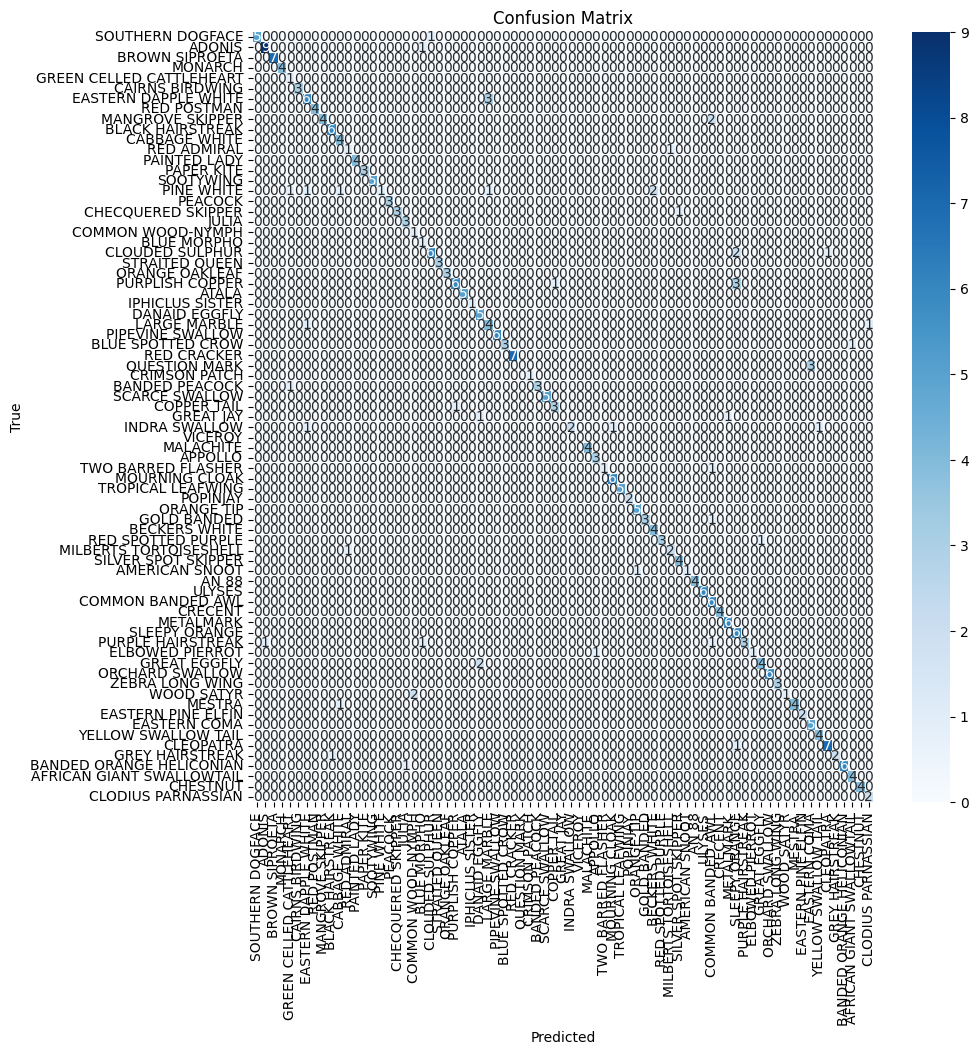

State:
	iteration: 1830
	epoch: 5
	epoch_length: 366
	max_epochs: 5
	output: 0.4197845160961151
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [25]:

breaker = EarlyStopping(patience=10, score_function=lambda engine: engine.state.metrics['accuracy'], trainer=trainer)
to_save = {'model': model}
saver = Checkpoint(to_save, './models', n_saved=1, filename_prefix='best', score_name="accuracy", global_step_transform=global_step_from_engine(trainer))
pbar = ProgressBar(persist=True, bar_format='')
pbar.attach(trainer, output_transform=lambda x: {"loss": x})

trainer.run(train_loader, max_epochs=5)

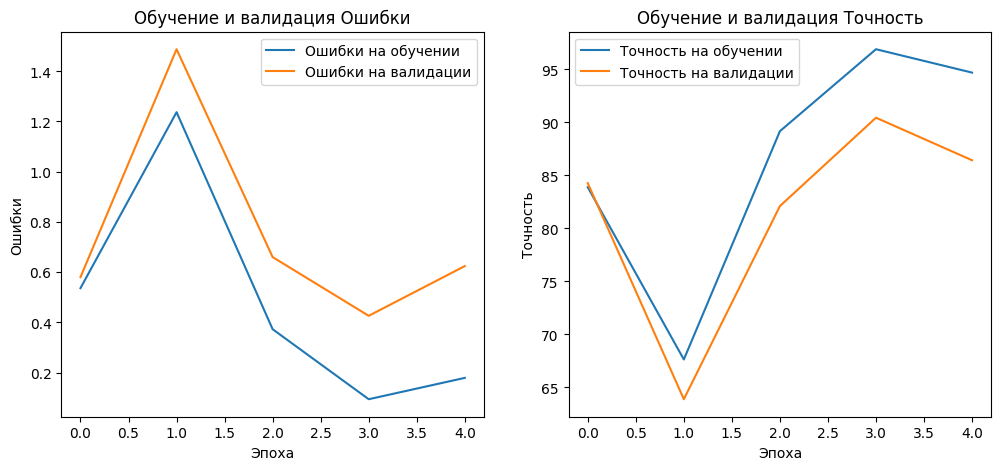

In [27]:
def plot_history(history, val_history, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Ошибки на обучении')
    plt.plot(val_history['loss'], label='Ошибки на валидации')
    plt.title(f'{title} Ошибки')
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибки')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Точность на обучении')
    plt.plot(val_history['accuracy'], label='Точность на валидации')
    plt.title(f'{title} Точность')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()

    plt.show()

plot_history(training_history, validation_history, 'Обучение и валидация')

## Выводы

1. Модель в целом правильно классифицирует большинство классов, но наблюдаются ошибки в некоторых местах, что связанно со схожестью некоторых видов бабочек.
2. Модель хорошо обучается, но есть признаки переобучения.